# Volatility Modeling with Applications to Risk

**Thomas Polstra, PhD**

**[GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)**

In [1]:
from IPython.display import display, Markdown

table_of_contents = '''


1. [Introduction](#Introduction)
2. [Black Scholes](#BlackScholes)
3. [Monte Carlo Simulation](#MCSimulation)
4. [Improving Monte Carlo Simulations with Control Variates](#BetterMC)
5. [Improving Monte-Carlo Simulations through a Static Hedge](#improveStatic)
6. [Improving Monte-Carlo Simulations through Dynamic Hedging](#Dynamic)
7. [Estimating Delta](#MC_Delta)
8. [Accurate European Option Pricing without Black Scholes](#Enhanced-Delta-Control-Variates)
'''

display(Markdown(table_of_contents))





1. [Introduction](#Introduction)
2. [Black Scholes](#BlackScholes)
3. [Monte Carlo Simulation](#MCSimulation)
4. [Improving Monte Carlo Simulations with Control Variates](#BetterMC)
5. [Improving Monte-Carlo Simulations through a Static Hedge](#improveStatic)
6. [Improving Monte-Carlo Simulations through Dynamic Hedging](#Dynamic)
7. [Estimating Delta](#MC_Delta)
8. [Accurate European Option Pricing without Black Scholes](#Enhanced-Delta-Control-Variates)


## Volatility  <a id='Introductions'>

- Volatility, a fundamental concept in the realm of financial markets, encapsulates the extent of fluctuation present in the prices or returns of financial assets across time.
- Its significance is twofold: First, volatility acts as a pivotal tool for comprehending and assessing risk associated with investments. Assets exhibiting higher volatility are often perceived as more precarious and unpredictable, making them a subject of meticulous scrutiny.
- Second, volatility's role extends to the valuation of options contracts. The dynamic nature of volatility directly influences option prices, rendering it a crucial factor for option traders and quantitative researchers alike.
- While basic techniques like simple moving averages can offer a preliminary insight into volatility, they may fall short in capturing its intricate temporal patterns. This deficiency has given rise to the demand for more advanced models, such as the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model, which excels in incorporating time-varying volatility patterns.
- Embracing the synergy between financial innovation and technological advancement, machine learning techniques have also stormed into the realm of volatility modeling. Techniques like Gradient Boosting and Random Forest, traditionally leveraged for predictive analytics, have found novel applications in forecasting and modeling volatility.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import anderson, zscore, norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
sns.set(style="darkgrid", palette = 'bright')

The following gathers stock price data for an individual ticker.

[*********************100%***********************]  1 of 1 completed


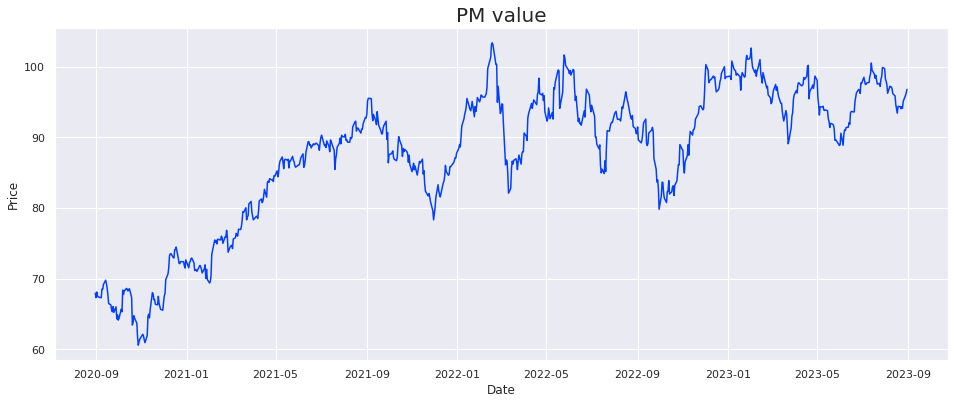

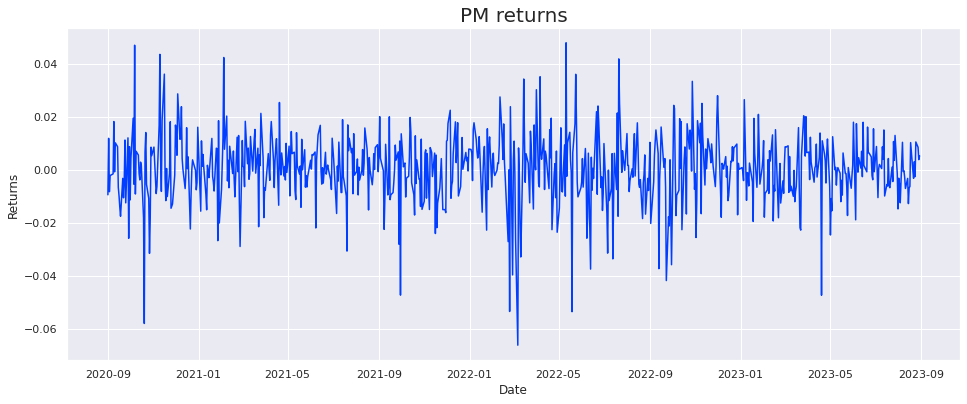

In [14]:
# Define the ticker symbol
ticker = 'PM'

# Define the date range
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(months=36)

# Retrieve the stock data for the S&P 500 index from Yahoo Finance
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data['returns'] = stock_data['Adj Close'].pct_change()
returns = stock_data['returns'].copy()
returns = returns.dropna()

# Data Visualization
plt.plot(stock_data['Adj Close'])
plt.title(''.join([ticker, ' value']), size = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.plot(returns)
plt.title(''.join([ticker,' returns']), size = 20)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

### Volatility estimate: One Month Rolling Volatility  <a id='baseline'>

In financial analysis, volatility is a key metric that measures the variation in the price or returns of a financial asset over time. A baseline approach to analyze volatility is by calculating rolling volatility measurements, which provide insights into the long-term historical stability and fluctuations of an asset's performance. In this context, we will focus on calculating one month rolling volatility for a stock's returns.

**Steps to Calculate One Month Rolling Volatility**

1. **Data Preparation**: Collect the historical daily price data for the stock. Ensure that the data covers a sufficient period to compute the rolling volatility over 22 trading days.

2. **Return Calculation**: Calculate the daily returns of the stock. Daily returns are typically computed as the percentage change in the stock's price from one day to the next:

3. **Calculate Rolling Volatility**: Calculate the rolling volatility over one month (21 trading days). This involves computing the standard deviation of the returns within a rolling window of 21 days.The mean of these values represents the average daily volatility of the stock. Rescaling by $\displaystyle \sqrt{252}$ provides the estimated (yearly) volatility of the stock's returns and can be used as a baseline for risk management and option pricing.

In [15]:
# Calculate the 30-day rolling standard deviation of returns and drop NaN values
moving_average_30d = stock_data.returns.rolling(window=21).std().dropna()

# Calculate the annualized volatility using the mean of the rolling standard deviations
yearly_volatility = moving_average_30d.mean() * np.sqrt(252)

# Print the result
print(f'The 30-day moving average volatility of {ticker} is {round(np.mean(yearly_volatility * 100), 2)}%')


The 30-day moving average volatility of PM is 19.92%


## GARCH  <a id='GARCH'>
    
Returns in financial markets often exhibit correlation with their previous values, indicating a degree of dependence over time. This temporal correlation is a fundamental aspect of financial data and can significantly impact risk assessment, option pricing, and portfolio management strategies. The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model proves to be an invaluable tool in addressing this phenomenon. By capturing the autocorrelation of volatility through its volatility model, GARCH acknowledges the intricate relationship between historical returns and their subsequent behavior. This acknowledgment is especially relevant in assessing risk and pricing financial instruments such as options, as it accommodates the ever-changing nature of volatility, which is essential for accurately modeling and understanding market dynamics. GARCH's ability to incorporate volatility persistence enhances its practicality in evaluating and predicting financial asset behavior, making it a staple in quantitative finance and risk management.
    
In line with the industry standard, we will proceed with using the GARCH(1,1) model to capture the volatility. More generally, one can model variance using a GARCH(p,q) model for different integer values for p and q. Higher values for p inform the model to consider a larger number of previous squared returns to model high and low volatility clusters. Higher values of q inform the model to consider the variance of a larger number of previous returns to influence the predicted volatility. Autocorrelation charts provide visuals that can be used to bring awareness of autocorrelation and statistical tests, such as the Ljung-Box test, can be used to detect if autocorrelation is present at a desired level of statistical significance.

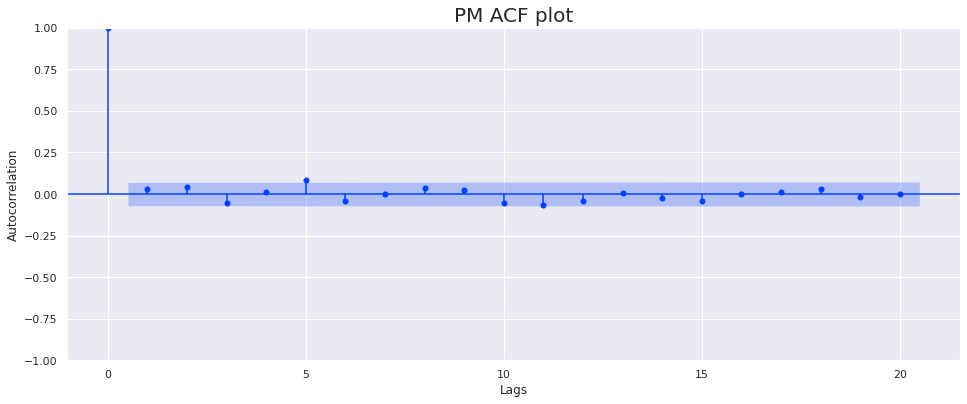

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox



# Plot the autocorrelation function (ACF) plot
plot_acf(returns, lags=20)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(''.join([ticker, ' ACF plot']), size = 20)
plt.show()

**GARCH Variants**

- In addition to the standard GARCH model, there are numerous variants that may be more suitable when evaluating various stocks and strategies. For example:
  - EGARCH (Exponential GARCH) accounts for asymmetric effects of positive and negative shocks on volatility.
  - GJR-GARCH (Generalized Autoregressive Conditional Heteroskedasticity with Skewness and Kurtosis) introduces additional parameters to model skewness and kurtosis in the return distribution.

**Estimating GARCH Parameters**

- GARCH(1,1) is an industry standard for predicting future volatility. However, modeling can be improved by adjusting the parameters of the model.
- Maximum Likelihood Estimation (MLE) is a techniqe to estimate parameter values that maximize the likelihood of the observed data, given the model assumptions, e.g. values are assumed to come from a normal distribution.

**Model Evaluation and Selection**

- Evaluating the performance of GARCH models is essential to ensure their adequacy.
- Common techniques for model evaluation include:
  - **Residual Analysis:** Examining the patterns in model residuals to check for any systematic patterns.
  - **Information Criteria:** Using information criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to compare different model specifications.
  - **Volatility Forecasting Accuracy:** Assessing how well the model forecasts future volatility compared to the actual observed values.

**Forecasting Volatility**

- Once the GARCH model is built and validated, it can be used for forecasting future volatility.
- Understanding volatility forecasts can help in making informed trading decisions and managing risk exposure.

### GARCH(1,1) volatility forecasting example

Let's start with a GARCH(1,1) model of the stock's volatility. We will train the model on the spanned trading days, except the last $21$. We will then compare the model's performance with the realized volatility over the testing period.

GARCH(1,1) forecasted volatility over testing period: 0.12507520428612195
-------
Realized volatility over testing period: 0.1126916833726846
-------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1190.23
Distribution:                  Normal   AIC:                           2388.46
Method:            Maximum Likelihood   BIC:                           2406.69
                                        No. Observations:                  704
Date:                Wed, Aug 30 2023   Df Residuals:                      703
Time:                        21:09:40   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0

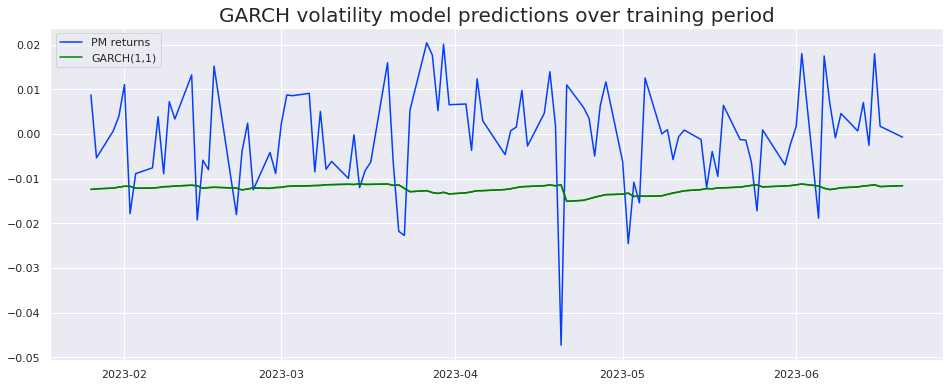

In [19]:
returns_data = stock_data['returns'].dropna()

# Split Data into Training and Testing Sets
testing_days = 50
testing_set = returns_data[-testing_days:]
training_set = returns_data[:-testing_days]
training_set_scaled = 100*training_set #Multiplying by 1000 makes the model run more accurately. Have to rescale outputs accordingly.

#Perform GARCH Modeling on the Training Set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1) 
results = garch_model.fit(disp='off')


# Calculate GARCH conditional volatility for the testing set
garch_volatility = results.conditional_volatility/100
projected_results = results.forecast(horizon = testing_days, reindex = 'False')

projected_results_variance = projected_results.variance.iloc[-1].values/100
forecasted_vol = np.sqrt(projected_results_variance).mean()


print(f'GARCH(1,1) forecasted volatility over testing period: {forecasted_vol}')
print('-------')
real_vol = testing_set.rolling(window = 20).std()[-1]*np.sqrt(252)
print(f'Realized volatility over testing period: {real_vol}')
print('-------')
print(results)



print('-------')
print('-------')

print('The GARCH(1,1) line represents represents (annualized) daily volatility predictions that were modeled over the training period.')
plt.plot(training_set[-100:], label = ''.join([ticker, ' returns']))
plt.plot(-garch_volatility[-100:],color = 'green', label = 'GARCH(1,1)')
plt.plot(-garch_volatility[-100:],color = 'green')
plt.title('GARCH volatility model predictions over training period', size = 20)
plt.legend()
plt.show()

### Analysis of GARCH Model Results

The provided printout offers valuable insights into the outcomes of a GARCH model estimation, a crucial technique for analyzing volatility patterns in financial time series data. GARCH models play an essential role in risk assessment and pricing financial instruments, particularly options, as they capture the evolving nature of volatility in asset returns.

**Forecasted and Realized Volatility**

During the testing period, the GARCH(1,1) model forecasted a volatility of approximately 0.125, while the realized volatility over the same period amounted to 0.112.

**Mean Model and Volatility Model Insights**

The results for the mean and volatility models are summarized below:

**Summary of Constant Mean - GARCH Model Results**
==============================================================================
| Dep. Variable:  returns  |  R-squared: 0.000  | Adj. R-squared: 0.000  |
| Mean Model:  Constant Mean  |  AIC: 2874.57  |  BIC: 2892.79  |
| Vol Model:  GARCH  |  No. Observations: 703  |  Df Residuals: 702  |
| Date: Sun, Aug 20 2023  |  Df Model: 1  |  Time: 12:29:36  |

Interpretation of these statistics will be integral to understanding the model's appropriateness and potential applications.

**Covariance Estimator: Robust**

The robust covariance estimator has been utilized in this analysis to enhance the reliability of the results.

**Mean Model: Constant Mean**
- The coefficient for the mean model ("mu") is approximately 0.1470.
- The standard error associated with this coefficient is 0.069, indicating a degree of uncertainty in the estimation.
- The t-statistic is 2.137, with a corresponding p-value of 0.032.
- The 95% confidence interval for the coefficient spans from around 0.012 to 0.282.

These findings suggest that the estimated constant mean of the returns is approximately 0.1470. The t-statistic indicates some evidence that the mean is different from zero, as the p-value is below 0.05.

**Volatility Model: GARCH**
- The estimated "omega" coefficient is approximately 0.0442.
- The standard error associated with "omega" is 0.0274.
- The t-statistic for "omega" is 1.610, with a p-value of 0.107.
- The 95% confidence interval for "omega" ranges between approximately -0.010 and 0.098.

**alpha[1] and beta[1] Coefficients**
- The estimated coefficient for "alpha[1]" is about 0.0450.
- The estimated coefficient for "beta[1]" is approximately 0.9405.
- Both coefficients have relatively low standard errors, and their p-values are statistically significant (p < 0.05).

These outcomes indicate that the GARCH model effectively captures autoregressive behavior in volatility. The "alpha[1]" coefficient reflects the impact of past squared returns on current volatility, while the "beta[1]" coefficient encapsulates the effect of prior volatility on current volatility. The "omega" coefficient contributes an initial level of volatility to the model's formulation. Additionally, due to the GARCH model's ability to capture autoregressive behavior in volatility, leveraging Monte Carlo simulations based on the predicted GARCH model could prove valuable in accurately valuing an option contract over the forecasted time horizon. This integration of volatility dynamics enhances the precision of option pricing, thereby aiding in more informed decision-making within the financial domain.

## VaR and CVaR

Accurate modeling of a portfolio's volatility which accomodates for autoregressive tendencies between short term returns, e.g. GARCH(1,1), allows investors to make informed decsions on a portfolio's risk.

### Value at Risk (VaR)

Value at Risk (VaR) is a widely used risk management metric in finance that estimates the potential loss of an investment or portfolio over a given time horizon and at a certain confidence level. VaR provides a numerical measure of the maximum expected loss under normal market conditions.

**Interpretation**

VaR is typically expressed as a negative value or loss amount. For example, if a stock has a VaR of -0.02 (or -2%), it means that there is a 5% (at 95% confidence level) chance that the stock's return will be worse than -2% over the specified time horizon.

**Calculation**

To calculate VaR, we use historical data on the investment's returns or price changes. The VaR is determined by estimating the volatility or standard deviation of the returns and then using a statistical method, such as the inverse of the cumulative distribution function, to find the threshold value corresponding to the desired confidence level.

**Example**

Let's consider an example: if a portfolio has a one-day VaR of -1.5% at a 95% confidence level, it means that there is a 5% chance that the portfolio's value will decrease by more than 1.5% in one trading day. In other words, if the portfolio's value is 1,000, there is a 5% chance that it will lose more than 15 in one day.

**Uses**

VaR is an essential tool for risk managers and investors to assess and quantify potential downside risk in their portfolios. It helps to set risk limits, allocate capital, and make informed decisions about risk exposure. Additionally, VaR allows investors to compare risk across different investments and identify those with lower or higher levels of risk.

However, it's crucial to recognize that VaR has limitations. It assumes that returns follow a normal distribution, which may not hold during extreme market conditions. VaR does not provide information about the magnitude of losses beyond the threshold, and it is a backward-looking measure based on historical data.

As such, VaR should be used in conjunction with other risk management tools and stress tests to provide a more comprehensive understanding of potential risks and losses.

In [20]:
# Set the confidence level for VaR (and CVaR) (95%)
confidence_level = 0.95

# Compute VaR using the inverse of the cumulative standard normal distribution
var = 1.0 * garch_volatility.quantile(1 - confidence_level)

print(f'Value at Risk at the {confidence_level*100:.2f}% confidence level: {var:.8f}')


Value at Risk at the 95.00% confidence level: 0.01099057


### Conditional Value at Risk (CVaR)

Conditional Value at Risk (CVaR), also known as Expected Shortfall (ES), is a risk management metric that complements Value at Risk (VaR). While VaR provides an estimate of the potential loss at a specific confidence level, CVaR goes a step further by measuring the average expected loss beyond the VaR threshold.

**Interpretation**

CVaR represents the expected value of the tail losses beyond the VaR threshold. It provides a more comprehensive view of the potential downside risk compared to VaR alone. If a portfolio has a VaR of -2% at a 95% confidence level and a CVaR of -3%, it means that, on days when the losses exceed the VaR threshold of -2%, the average loss is expected to be around -3%.

**Calculation**

To calculate CVaR, we first determine the VaR at the desired confidence level. Then, we take the average of all losses beyond the VaR threshold. Mathematically, CVaR is the integral of the loss distribution in the tail beyond the VaR threshold, divided by the probability of the tail event. CVaR can also be approximated as the average of the losses exceeding the VaR.


**Uses**

CVaR is a valuable metric for risk managers and investors seeking to understand the extent of potential losses beyond the VaR level. Unlike VaR, which only provides a threshold value, CVaR gives insight into the expected magnitude of extreme losses. This information is crucial for developing risk mitigation strategies, determining appropriate hedging measures, and optimizing portfolio allocation.



In [21]:
# Compute CVaR as the expected loss beyond VaR
cvar = 1.0 * garch_volatility[garch_volatility <= var].mean()

print(f'CVaR at {confidence_level*100:.2f}% confidence level: {cvar:.8f}')

CVaR at 95.00% confidence level: 0.01070707


### A note of caution

VaR and CVaR calculations through GARCH modeling are subject to certain limitations. The current parameters being used in our models assume that the return data is stationary and normally distributed. We conduct standard statistical tests on the returns of the index during the testing period, using a significance level (p-value) of 0.05, to test if the returns of our index are stationary and normally distributed.

In [22]:
# Perform the ADF test
result = adfuller(returns_data)

# Extract the p-value from the test result
p_value = result[1]

# Check if the data is stationary based on the p-value
if p_value <= 0.05:
    print("The stock returns are likely stationary.")
else:
    print("The stock returns are likely non-stationary.")


# Perform the Anderson-Darling test
result = anderson(returns_data)

# Extract the critical values and the significance levels from the test result
critical_values = result.critical_values
significance_level = result.significance_level[2] #set p-value to .05

# Check if the data is normally distributed based on the test statistic and critical values
if result.statistic < significance_level:
    print(f"The stock returns are likely normally distributed.")
else:
    print(f"The stock returns are likely not normally distributed.")


The stock returns are likely stationary.
The stock returns are likely normally distributed.


### GARCH, Var, and CVaR for strategy returns.

VaR and CVaR is often times better suited for the returns on a strategies returns.

We upload the returns on a portfolio of diversified long-short equity strategy returns. We will test if the returns are stationary and normally distributed (they will be). We then utilize GARCH modeling to measure the VaR and cVaR of the portfolio.

In [23]:
#Upload the returns of a strategy and the various stocks in the strategy over a backtesting period of 6 months.
strategy_df_returns = pd.read_csv('strat.csv')

print(strategy_df_returns.head())

strat_returns = strategy_df_returns['Strategy_Return'].dropna() 

       TSLA       AMD      AMZN      AAPL      NVDA       BAC         T  \
0 -0.029039 -0.036035 -0.023726 -0.010605 -0.032816 -0.002050  0.003657   
1  0.024651  0.026151  0.035611  0.036794  0.041640  0.009979  0.016658   
2  0.059349  0.051282  0.014870  0.004089  0.051753 -0.015112 -0.011012   
3 -0.007681  0.012046  0.028732  0.004456  0.017981  0.006787  0.022584   
4  0.036769  0.014842  0.058084  0.021112  0.005783  0.007620 -0.003082   

       INTC     GOOGL      MSFT  ...       APD       AON      REGN       BLK  \
0 -0.004335 -0.021344 -0.029638  ...  0.015558  0.007829  0.003758  0.028619   
1  0.042453  0.013225  0.011785  ... -0.027699 -0.023240 -0.018501 -0.052421   
2  0.020188  0.007786  0.009736  ... -0.004804  0.003254  0.076864 -0.020312   
3  0.004435  0.004544  0.007617  ... -0.003209 -0.003265 -0.027128 -0.005697   
4  0.013927  0.035060  0.030238  ... -0.000320 -0.015814 -0.015724  0.001796   

       EQIX      BKNG       CMG     ^GSPC  Strategy_Value  Strategy_

In [24]:
# Perform the ADF test
result = adfuller(strat_returns)

# Extract the p-value from the test result
p_value = result[1]

# Check if the data is stationary based on the p-value
if p_value <= 0.05:
    print("The strategy returns are likely stationary.")
else:
    print("The strategy returns are likely non-stationary.")


# Perform the Anderson-Darling test
result = anderson(strat_returns)

# Extract the critical values and the significance levels from the test result
critical_values = result.critical_values
significance_level = result.significance_level[2] #set p-value to .05

# Check if the data is normally distributed based on the test statistic and critical values
if result.statistic < significance_level:
    print(f"The strategy returns are likely normally distributed.")
else:
    print(f"The strategy returns are likely not normally distributed.")
    



The strategy returns are likely stationary.
The strategy returns are likely normally distributed.


GARCH(1,1) forecasted volatility over testing period: 0.0770222625668747
-------
Realized volatility over testing period: 0.050043171499983136
-------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:        Strategy_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -209.553
Distribution:                  Normal   AIC:                           427.106
Method:            Maximum Likelihood   BIC:                           437.150
                                        No. Observations:                   91
Date:                Wed, Aug 30 2023   Df Residuals:                       90
Time:                        21:11:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Con

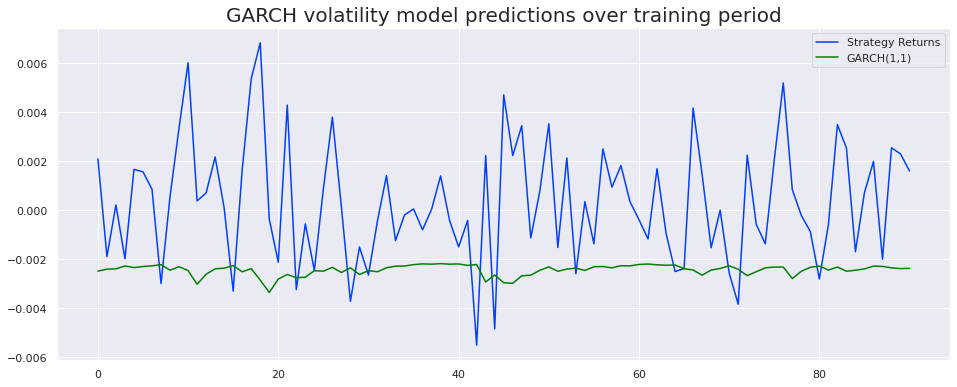

-------
-------
Value at Risk at the 95.00% confidence level: 0.00220075
CVaR at 95.00% confidence level: 0.00219025


In [25]:
# Split Data into Training and Testing Sets
testing_set = strat_returns.iloc[-testing_days:]
training_set = strat_returns.iloc[:-testing_days]

# Perform GARCH Modeling on the Training Set
# Rescale the data (multiply by 100)
training_set_scaled = training_set *1000

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1)
results = garch_model.fit(disp='off')

# Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-100:]/1000





projected_results = results.forecast(horizon = testing_days, reindex = 'False')

projected_results_variance = projected_results.variance.iloc[-1].values/1000
forecasted_vol = np.sqrt(projected_results_variance).mean()


print(f'GARCH(1,1) forecasted volatility over testing period: {forecasted_vol}')
print('-------')
real_vol = testing_set.std()*np.sqrt(252)
print(f'Realized volatility over testing period: {real_vol}')
print('-------')
print(results)

print('-------')
print('-------')

plt.plot(training_set[-100:].values, label = 'Strategy Returns')
plt.plot(-garch_volatility_rescaled[-100:].values,color = 'green', label = 'GARCH(1,1)')
plt.title('GARCH volatility model predictions over training period', size = 20)
plt.legend()
plt.show()


print('-------')
print('-------')




# Set the confidence level for VaR (and CVaR) (95%)
confidence_level = .95

# Compute VaR using the inverse of the cumulative standard normal distribution
var = 1.0 * garch_volatility_rescaled.quantile(1 - confidence_level)

print(f'Value at Risk at the {confidence_level*100:.2f}% confidence level: {var:.8f}')


# Drop NaN values from garch_volatility_rescaled to handle missing values
garch_volatility_rescaled_cleaned = garch_volatility_rescaled.dropna()

# Compute CVaR as the expected loss beyond VaR
cvar = 1.0 * garch_volatility_rescaled_cleaned[garch_volatility_rescaled_cleaned <= var].mean()

print(f'CVaR at {confidence_level*100:.2f}% confidence level: {cvar:.8f}')


## Machine Learning Models and Value at Risk


### Gradient Boosting

Gradient Boosting is a popular machine learning technique used for both classification and regression tasks. It is an ensemble learning method that combines multiple weak learners (individual decision trees) to create a powerful and accurate prediction model. Like Random Forest, Gradient Boosting is known for its high accuracy and robustness, making it a valuable tool in various applications.

**How Gradient Boosting Works**

1. **Ensemble Learning**: Gradient Boosting follows the ensemble learning approach, where weak learners are sequentially combined to create a strong learner.

2. **Boosting**: Unlike Random Forest's parallel approach, Gradient Boosting uses a sequential boosting process. It starts by fitting a single decision tree to the data, and then additional trees are built to correct the errors made by the previous ones.

3. **Residual Fitting**: Each subsequent decision tree is trained on the negative gradient (residual) of the loss function with respect to the previous tree's predictions. This step ensures that each new tree focuses on the mistakes made by the ensemble so far.

4. **Weighted Voting**: In the prediction stage, each decision tree contributes to the final prediction based on its performance during training. Trees with lower errors have higher weights, leading to a more accurate overall prediction.

**Advantages of Gradient Boosting**

1. **High Accuracy**: Gradient Boosting is well-known for its high predictive accuracy, making it effective in capturing complex patterns in the data.

2. **Robustness**: Similar to Random Forest, Gradient Boosting is less prone to overfitting, providing a robust model.

3. **Feature Importance**: It offers insights into feature importance, allowing users to identify the most influential features in the prediction process.

4. **Flexible for Various Tasks**: Gradient Boosting is versatile and can be applied to both classification and regression tasks.

**Limitations of Gradient Boosting**

1. **Computationally Expensive**: Building the ensemble sequentially can be time-consuming, especially when dealing with a large number of trees.

2. **Hyperparameter Tuning**: Fine-tuning the hyperparameters of the model can be challenging, as the optimal settings may vary depending on the data.

3. **Interpretability**: Like Random Forest, the combined decision of multiple trees can be challenging to interpret, leading to a less interpretable model.

**Summary**

Gradient Boosting is a powerful machine learning technique that leverages the strength of decision trees and ensemble learning to achieve high accuracy and robustness. Its boosting process and weighted voting strategy enable it to improve the prediction performance with each additional tree. Despite being computationally expensive and less interpretable, Gradient Boosting's advantages, such as accuracy and feature importance insights, make it a valuable tool for various machine learning tasks.

Root of mean squared error of the GARCH(1,1) 95% confidence interval: 0.0036220433693322715
---
---
Root of mean squared error of Gradient Boosting at 95% confidence interval: 0.0005700568248652737
---
---


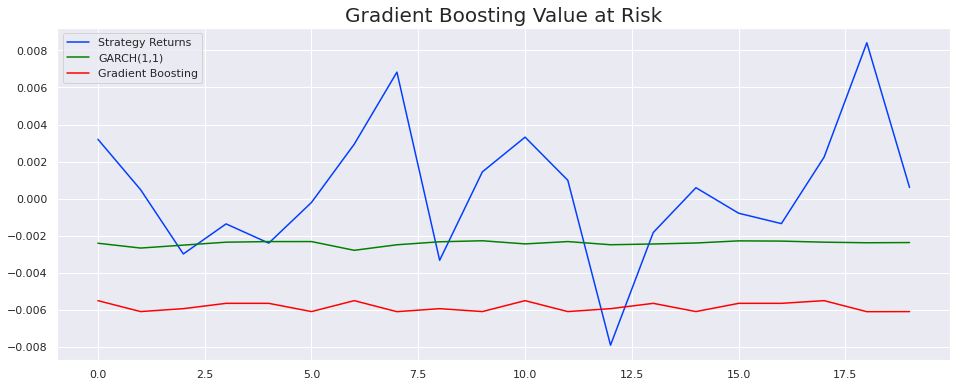

In [26]:
# Split Data into Training and Testing Sets
# Assuming you have the testing set as the last 23 data points of the features_df
strategy_df_returns['historical_VaR'] = strategy_df_returns['Strategy_Return'].rolling(23).std()*1.959964
strategy_df_returns = strategy_df_returns


X_train = strategy_df_returns['Strategy_Return'][117:-20]
X_test = strategy_df_returns['Strategy_Return'][-20:]

# Train the Gradient Boosting Model
y_train = strategy_df_returns['historical_VaR'][117:-20]
y_test = strategy_df_returns['historical_VaR'][-20:]

# Initialize and train the Gradient Boosting model
X_train_reshaped = X_train.values.reshape(-1, 1)  # Reshape to a 2D array
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(X_train_reshaped, y_train)


# Predict Volatility
X_test_reshaped = X_test.values.reshape(-1, 1)
y_pred = gb_model.predict(X_test_reshaped)





# Compute Root Mean Squared Error of the GARCH(1,1) 95% confidence interval
arr1 = strategy_df_returns['historical_VaR'][-20:]
arr2 = garch_volatility_rescaled
arr3 = y_pred
garch_mse = sum((x - y) ** 2 for x, y in zip(arr1, arr2))/len(arr1)
print(f'Root of mean squared error of the GARCH(1,1) 95% confidence interval: {np.sqrt(garch_mse)}' )
print('---')
print('---')
gradient_mse = sum((x - y) ** 2 for x, y in zip(arr1, arr3))/len(arr1)
print(f'Root of mean squared error of Gradient Boosting at 95% confidence interval: {np.sqrt(gradient_mse)}' )
print('---')
print('---')

plt.plot(strategy_df_returns['Strategy_Return'].values[-20:], label = 'Strategy Returns')
plt.plot(-garch_volatility_rescaled[-20:].values,color = 'green', label = 'GARCH(1,1)')
plt.plot(-y_pred[-20:],color = 'red', label = 'Gradient Boosting')
plt.title('Gradient Boosting Value at Risk', size = 20)
plt.legend()
plt.show()

### Random Forest

- Random Forest is an ensemble learning method widely used in machine learning for classification and regression tasks.
- It is based on the idea of combining multiple decision trees to create a more robust and accurate prediction model.
- Random Forest is known for its high accuracy, versatility, and resistance to overfitting.

**How Random Forest Works**

1. **Ensemble Learning**: Random Forest is an example of ensemble learning, where multiple weak learners (individual decision trees) are combined to create a strong learner (the random forest).

2. **Bootstrap Aggregating (Bagging)**: The process starts by randomly selecting subsets of the training data (with replacement). Each subset is called a bootstrap sample, and it is used to train a separate decision tree.

3. **Random Feature Selection**: At each node of the decision tree, a random subset of features is considered for splitting. This randomization helps reduce the correlation between trees and promotes diversity.

4. **Decision Tree Building**: Each decision tree is constructed using the bootstrap sample and random feature set. The tree is grown until a stopping criterion is met, typically when a certain depth is reached or the leaf nodes contain a minimum number of samples.

5. **Voting and Averaging**: For classification tasks, the final prediction is made by majority voting among all the decision trees. For regression tasks, the final prediction is obtained by averaging the predictions of all trees.

**Advantages of Random Forest**

1. **High Accuracy**: Random Forest generally yields high accuracy due to its ensemble nature and ability to capture complex patterns in the data.

2. **Robustness**: It is less prone to overfitting compared to individual decision trees.

3. **Versatility**: Random Forest can handle both classification and regression tasks.

4. **Feature Importance**: It provides a measure of feature importance, indicating which features are most relevant for the prediction.

5. **Parallelization**: The training of decision trees can be easily parallelized, making it efficient for large datasets.

**Limitations of Random Forest**

1. **Black Box Model**: Interpretability can be a challenge, as the combined decision of multiple trees can be complex to understand.

2. **Data with Many Features**: Random Forest may not perform well on datasets with a large number of features.

3. **Overfitting Risk**: Although less prone to overfitting, it can still occur if the number of trees is too large.

**Summary**

Random Forest is a powerful machine learning algorithm that leverages the strength of decision trees and ensemble learning to achieve high accuracy and robustness. By combining multiple decision trees and randomizing feature selection, Random Forest is effective in various applications, including classification, regression, and feature importance analysis.

Root of mean squared error of the GARCH(1,1) 95% confidence interval: 0.0037060374412275394
---
---
Root of mean squared error of Random Forest at 95% confidence interval: 0.0005525740393742277
---
---


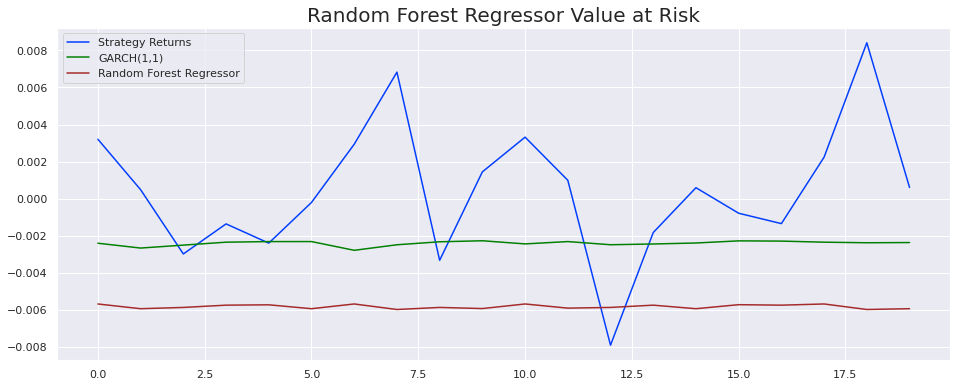

In [27]:
# Split Data into Training and Testing Sets
# Assuming you have the testing set as the last 23 data points of the features_df
strategy_df_returns['historical_VaR'] = strategy_df_returns['Strategy_Return'].rolling(23).std()*1.959964
strategy_df_returns = strategy_df_returns


X_train = strategy_df_returns['Strategy_Return'][117:-20]
X_test = strategy_df_returns['Strategy_Return'][-20:]

# Train the Random Forest Model
y_train = strategy_df_returns['historical_VaR'][117:-20]
y_test = strategy_df_returns['historical_VaR'][-20:]


X_train_reshaped = X_train.values.reshape(-1, 1)  # Reshape to a 2D array
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_reshaped, y_train)


# Predict Volatility
X_test_reshaped = X_test.values.reshape(-1, 1)
y_pred = rf_model.predict(X_test_reshaped)





# Compute Root Mean Squared Error of the GARCH(1,1) 95% confidence interval
arr1 = strategy_df_returns['historical_VaR'][-20:]
arr2 = garch_volatility_rescaled[-20:]
arr3 = y_pred
garch_mse = sum((x - y) ** 2 for x, y in zip(arr1, arr2))/len(arr1)
print(f'Root of mean squared error of the GARCH(1,1) 95% confidence interval: {np.sqrt(garch_mse)}' )
print('---')
print('---')
gradient_mse = sum((x - y) ** 2 for x, y in zip(arr1, arr3))/len(arr1)
print(f'Root of mean squared error of Random Forest at 95% confidence interval: {np.sqrt(gradient_mse)}' )
print('---')
print('---')

plt.plot(strategy_df_returns['Strategy_Return'].values[-20:], label = 'Strategy Returns')
plt.plot(-garch_volatility_rescaled[-20:].values,color = 'green', label = 'GARCH(1,1)')
plt.plot(-y_pred[-20:],color = 'brown', label = 'Random Forest Regressor')
plt.title('Random Forest Regressor Value at Risk', size = 20)
plt.legend()
plt.show()